<h1>SI 670 Kaggle Competition 4</h1>

Team GSIs

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras import Model, Sequential, layers
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import Input 

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Load datasets</h2>

In [4]:
len(list(os.listdir("../data/images_train/bathroom"))), len(list(os.listdir("../data/images_train/kitchen")))

FileNotFoundError: [Errno 2] No such file or directory: '../data/images_train/bathroom'

In [9]:
data = tf.keras.utils.image_dataset_from_directory("../images_train", 
                                                   image_size = (256, 256), 
                                                   class_names = ['bathroom', 'kitchen'], 
                                                   shuffle = True,
                                                   batch_size = 32)

# run

Found 616 files belonging to 2 classes.


2023-11-22 19:32:13.755942: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-22 19:32:13.755974: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-22 19:32:13.755982: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-22 19:32:13.756017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 19:32:13.756033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
X, y = zip(*data)

X = np.concatenate(X)
y = np.concatenate(y)
# run

In [11]:
len(X), len(y)
# run

(616, 616)

In [53]:
img_width, img_height = 256, 256
batch_size = 8

In [51]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, shear_range=0.2, zoom_range=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [59]:
train_generator = train_datagen.flow_from_directory("../images_train", target_size=(img_width, img_height), batch_size=8, class_mode='binary')


Found 616 images belonging to 2 classes.


<h2>Preprocess Images</h2>

In [12]:
#flip labels so bathroom is 1
y = np.where(y == 1, 0, 1)
# run

In [55]:
X = np.apply_along_axis(lambda s: s / 255.0, axis = 1, arr = X)

<h2>Split</h2>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
# run

In [30]:
train_datagen.fit(X_train)
# X_val = train_datagen.fit(X_val)
test_datagen.fit(X_test)

In [175]:
test_datagen.fit(X_test)

<h2>Train Model</h2>

In [ ]:
def skip_block(x):
    x_skip = x.copy()

    x = tf.keras.layers.Conv2D(64, (3, 3), strides = (2, 2), kernel_regularizer = l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D()

In [39]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invertx = random_invert()

In [8]:
IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  # random_invert(),
])

# run

In [22]:
IMG_SIZE = 256

model = Sequential([
    # resize_and_rescale,
    # data_augmentation,
    #layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),

    layers.Conv2D(128, (3,3), activation='relu',  kernel_regularizer = l2(0.0001)),
    layers.MaxPooling2D(),
    layers.Conv2D(256,(3,3), activation='relu',  kernel_regularizer = l2(0.0001)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3),  activation='relu'),
    layers.MaxPooling2D(3,3),
    layers.Flatten(),
    layers.Dense(64),
    layers.Dense(1, activation='sigmoid'),
    # input
    # tf.keras.layers.Conv2D(128, (3, 3), input_shape = (256, 256, 3)), 
    # # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5),  
    # # tf.keras.layers.BatchNormalization(axis = -1),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'), 

    
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    # # tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 
    # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    # tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'), 

    
    # # tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = (256, 256, 3)), 
    # # tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    # # tf.keras.layers.Dropout(0.1),
    # # tf.keras.layers.Conv2D(86, (3, 3), activation = 'relu'),
    # # tf.keras.layers.MaxPooling2D((3, 3)),
    # tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    # # tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    # tf.keras.layers.Dropout(0.01),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Flatten(), 
    # tf.keras.layers.Dense(50), 
    # tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [6]:
model = Sequential([
    # input
    resize_and_rescale,
    data_augmentation,
    # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    # tf.keras.layers.MaxPooling2D((3, 3)),
    # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((3, 3)),   
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer = l2(0.0001), input_shape = (256, 256, 3)), 
    tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5),  
    
    # tf.keras.layers.Conv2D(64, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'), 

    
    tf.keras.layers.MaxPooling2D((3, 3)),
    # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    # tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 
    # tf.keras.layers.BatchNormalization(axis = -1, epsilon = 2e-5, input_shape = (256, 256, 3)), 
    # tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer = l2(0.0001), activation = 'relu'), 

    
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (256, 256, 3)), 
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), 
    # tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu'), 
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64), 
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# run

NameError: name 'Sequential' is not defined

In [23]:
loss = BinaryCrossentropy()
model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])
# keras adam optimizer
# tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)


# run

In [60]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 3, restore_best_weights = True)
model.fit(
    train_generator,
    epochs=10)
    # validation_data=validation_generator,
    # validation_steps=800)

Epoch 1/10
77/77 [==============================] - 52s 670ms/step - loss: 0.6716 - accuracy: 0.5974
Epoch 2/10
77/77 [==============================] - 52s 679ms/step - loss: 0.5461 - accuracy: 0.7029
Epoch 3/10
77/77 [==============================] - 52s 675ms/step - loss: 0.4193 - accuracy: 0.8214
Epoch 4/10
77/77 [==============================] - 52s 670ms/step - loss: 0.3748 - accuracy: 0.8425
Epoch 5/10
77/77 [==============================] - 52s 674ms/step - loss: 0.3512 - accuracy: 0.8474
Epoch 6/10
77/77 [==============================] - 52s 670ms/step - loss: 0.3366 - accuracy: 0.8815
Epoch 7/10
77/77 [==============================] - 52s 671ms/step - loss: 0.3618 - accuracy: 0.8442
Epoch 8/10
60/77 [======================>.......] - ETA: 11s - loss: 0.3665 - accuracy: 0.8292

KeyboardInterrupt: 

In [69]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf

In [24]:
early_stopping = EarlyStopping(monitor = 'accuracy', min_delta = 0.001, patience = 3, restore_best_weights = True)
# didnt do validation, just train and test
# model_history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32,
#          subset='training'), epochs = 15, 
#                         #   callbacks = [early_stopping], 
#                           validation_data = train_datagen.flow(X_train, y_train, batch_size=8, subset="validation") )

model_history = model.fit(X_train, y_train, epochs = 15, batch_size = 8, callbacks = [early_stopping])

                          # validation_data = (X_val, y_val))


# run

Epoch 1/15


2023-11-22 19:35:25.425805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/62 [..............................] - ETA: 8s - loss: 1.7683 - accuracy: 0.5000  

2023-11-22 19:35:25.894076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:26.042636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/62 [>.............................] - ETA: 8s - loss: 1.2142 - accuracy: 0.5312

2023-11-22 19:35:26.189223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:26.332016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/62 [=>............................] - ETA: 8s - loss: 1.0400 - accuracy: 0.5625

2023-11-22 19:35:26.477143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:26.619638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/62 [==>...........................] - ETA: 7s - loss: 0.9829 - accuracy: 0.5312

2023-11-22 19:35:26.765437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:26.907602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/62 [===>..........................] - ETA: 7s - loss: 0.9228 - accuracy: 0.5625

2023-11-22 19:35:27.050025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:27.190552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/62 [====>.........................] - ETA: 7s - loss: 0.8849 - accuracy: 0.5625

2023-11-22 19:35:27.334654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:27.478673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/62 [=====>........................] - ETA: 6s - loss: 0.8615 - accuracy: 0.5446

2023-11-22 19:35:27.618830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:27.759824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/62 [======>.......................] - ETA: 6s - loss: 0.8437 - accuracy: 0.5312

2023-11-22 19:35:27.906472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:28.057110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/62 [=======>......................] - ETA: 6s - loss: 0.8274 - accuracy: 0.5278

2023-11-22 19:35:28.204077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:28.350605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/62 [========>.....................] - ETA: 6s - loss: 0.8150 - accuracy: 0.5375

2023-11-22 19:35:28.494260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:28.637392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/62 [=========>....................] - ETA: 5s - loss: 0.8048 - accuracy: 0.5398

2023-11-22 19:35:28.775653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:28.916467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/62 [==========>...................] - ETA: 5s - loss: 0.7917 - accuracy: 0.5521

2023-11-22 19:35:29.058228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:29.199984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/62 [===========>..................] - ETA: 5s - loss: 0.7934 - accuracy: 0.5385

2023-11-22 19:35:29.339007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:29.503547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/62 [============>.................] - ETA: 4s - loss: 0.7874 - accuracy: 0.5357

2023-11-22 19:35:29.648410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:29.798416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/62 [=============>................] - ETA: 4s - loss: 0.7811 - accuracy: 0.5417

2023-11-22 19:35:29.943455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:30.086009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/62 [==============>...............] - ETA: 4s - loss: 0.7765 - accuracy: 0.5391

2023-11-22 19:35:30.230175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:30.375152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/62 [===============>..............] - ETA: 4s - loss: 0.7722 - accuracy: 0.5368

2023-11-22 19:35:30.518605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:30.661161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/62 [================>.............] - ETA: 3s - loss: 0.7681 - accuracy: 0.5347

2023-11-22 19:35:30.803339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:30.947699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/62 [=================>............] - ETA: 3s - loss: 0.7642 - accuracy: 0.5362

2023-11-22 19:35:31.086102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:31.226394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/62 [==================>...........] - ETA: 3s - loss: 0.7619 - accuracy: 0.5312

2023-11-22 19:35:31.406387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:31.551998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/62 [===================>..........] - ETA: 2s - loss: 0.7586 - accuracy: 0.5327

2023-11-22 19:35:31.694242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:31.835237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/62 [====================>.........] - ETA: 2s - loss: 0.7556 - accuracy: 0.5455

2023-11-22 19:35:31.976982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:32.116719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/62 [=====================>........] - ETA: 2s - loss: 0.7527 - accuracy: 0.5543

2023-11-22 19:35:32.257735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:32.400022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/62 [======================>.......] - ETA: 2s - loss: 0.7490 - accuracy: 0.5651

2023-11-22 19:35:32.539806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:32.680158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/62 [=======================>......] - ETA: 1s - loss: 0.7558 - accuracy: 0.5600

2023-11-22 19:35:32.820373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:32.959057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/62 [========================>.....] - ETA: 1s - loss: 0.7546 - accuracy: 0.5577

2023-11-22 19:35:33.100942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:33.240103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/62 [=========================>....] - ETA: 1s - loss: 0.7517 - accuracy: 0.5625

2023-11-22 19:35:33.383552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:33.527193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/62 [==========================>...] - ETA: 0s - loss: 0.7490 - accuracy: 0.5647

2023-11-22 19:35:33.671801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:33.820814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/62 [===========================>..] - ETA: 0s - loss: 0.7483 - accuracy: 0.5603

2023-11-22 19:35:33.965937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:34.110473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/62 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.5562

2023-11-22 19:35:34.255016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:34.423870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/62 [============================>.] - ETA: 0s - loss: 0.7446 - accuracy: 0.5615

2023-11-22 19:35:34.575047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/62 [==============================] - 11s 148ms/step - loss: 0.7449 - accuracy: 0.5589
Epoch 2/15
 1/62 [..............................] - ETA: 9s - loss: 0.7431 - accuracy: 0.3750

2023-11-22 19:35:34.909659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:35.063602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/62 [>.............................] - ETA: 8s - loss: 0.7253 - accuracy: 0.3750

2023-11-22 19:35:35.211934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:35.354537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/62 [=>............................] - ETA: 8s - loss: 0.7064 - accuracy: 0.4500

2023-11-22 19:35:35.495891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:35.644173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/62 [==>...........................] - ETA: 8s - loss: 0.6861 - accuracy: 0.5357

2023-11-22 19:35:35.801748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:35.958437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/62 [===>..........................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5417

2023-11-22 19:35:36.114650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:36.261200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/62 [====>.........................] - ETA: 7s - loss: 0.7131 - accuracy: 0.5227

2023-11-22 19:35:36.407195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:36.561487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/62 [=====>........................] - ETA: 7s - loss: 0.7128 - accuracy: 0.5192

2023-11-22 19:35:36.704386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:36.843623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/62 [======>.......................] - ETA: 6s - loss: 0.7125 - accuracy: 0.5083

2023-11-22 19:35:36.982302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:37.120461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/62 [=======>......................] - ETA: 6s - loss: 0.7102 - accuracy: 0.5221

2023-11-22 19:35:37.259282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:37.399274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/62 [========>.....................] - ETA: 6s - loss: 0.7084 - accuracy: 0.5263

2023-11-22 19:35:37.539084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:37.678186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/62 [=========>....................] - ETA: 5s - loss: 0.7083 - accuracy: 0.5179

2023-11-22 19:35:37.816965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:37.957232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/62 [==========>...................] - ETA: 5s - loss: 0.7084 - accuracy: 0.5109

2023-11-22 19:35:38.098282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:38.239430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/62 [===========>..................] - ETA: 5s - loss: 0.7064 - accuracy: 0.5200

2023-11-22 19:35:38.378127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:38.518698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/62 [============>.................] - ETA: 5s - loss: 0.7072 - accuracy: 0.5046

2023-11-22 19:35:38.659038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:38.798879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/62 [=============>................] - ETA: 4s - loss: 0.7056 - accuracy: 0.5172

2023-11-22 19:35:38.938461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:39.077811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/62 [==============>...............] - ETA: 4s - loss: 0.7038 - accuracy: 0.5282

2023-11-22 19:35:39.219023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:39.359089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/62 [==============>...............] - ETA: 4s - loss: 0.7001 - accuracy: 0.5492

2023-11-22 19:35:39.500451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:39.640179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/62 [===============>..............] - ETA: 3s - loss: 0.7001 - accuracy: 0.5429

2023-11-22 19:35:39.780718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:39.922171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/62 [================>.............] - ETA: 3s - loss: 0.6968 - accuracy: 0.5473

2023-11-22 19:35:40.062966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:40.213012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/62 [=================>............] - ETA: 3s - loss: 0.7002 - accuracy: 0.5353

2023-11-22 19:35:40.349249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:40.490146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/62 [==================>...........] - ETA: 2s - loss: 0.6956 - accuracy: 0.5488

2023-11-22 19:35:40.629635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:40.767983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/62 [===================>..........] - ETA: 2s - loss: 0.7041 - accuracy: 0.5378

2023-11-22 19:35:40.904602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:41.041432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/62 [====================>.........] - ETA: 2s - loss: 0.7026 - accuracy: 0.5417

2023-11-22 19:35:41.179570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:41.325773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/62 [=====================>........] - ETA: 2s - loss: 0.6974 - accuracy: 0.5532

2023-11-22 19:35:41.475819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:41.625241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/62 [======================>.......] - ETA: 1s - loss: 0.6955 - accuracy: 0.5536

2023-11-22 19:35:41.776159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:41.954160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/62 [=======================>......] - ETA: 1s - loss: 0.6982 - accuracy: 0.5490

2023-11-22 19:35:42.111770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:42.259442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/62 [========================>.....] - ETA: 1s - loss: 0.6997 - accuracy: 0.5448

2023-11-22 19:35:42.407947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:42.557290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/62 [=========================>....] - ETA: 1s - loss: 0.6978 - accuracy: 0.5523

2023-11-22 19:35:42.703327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:42.846692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/62 [==========================>...] - ETA: 0s - loss: 0.6970 - accuracy: 0.5526

2023-11-22 19:35:42.991699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:43.137919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/62 [===========================>..] - ETA: 0s - loss: 0.6899 - accuracy: 0.5593

2023-11-22 19:35:43.292246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:43.436049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/62 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5574

2023-11-22 19:35:43.581788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:43.735368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/62 [==============================] - 9s 144ms/step - loss: 0.6888 - accuracy: 0.5589
Epoch 3/15
 1/62 [..............................] - ETA: 8s - loss: 0.6449 - accuracy: 0.6250

2023-11-22 19:35:43.852780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:43.993577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/62 [>.............................] - ETA: 8s - loss: 0.6595 - accuracy: 0.5000

2023-11-22 19:35:44.134386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:44.275808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/62 [=>............................] - ETA: 8s - loss: 0.5728 - accuracy: 0.6250

2023-11-22 19:35:44.415655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:44.557550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/62 [==>...........................] - ETA: 7s - loss: 0.6456 - accuracy: 0.6250

2023-11-22 19:35:44.699236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:44.845176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/62 [===>..........................] - ETA: 7s - loss: 0.6440 - accuracy: 0.6389

2023-11-22 19:35:45.001626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:45.142289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/62 [====>.........................] - ETA: 7s - loss: 0.6511 - accuracy: 0.6705

2023-11-22 19:35:45.283894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:45.425549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/62 [=====>........................] - ETA: 6s - loss: 0.6449 - accuracy: 0.6731

2023-11-22 19:35:45.565553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:45.705106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/62 [======>.......................] - ETA: 6s - loss: 0.6357 - accuracy: 0.6833

2023-11-22 19:35:45.847969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:45.987820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/62 [=======>......................] - ETA: 6s - loss: 0.6305 - accuracy: 0.6691

2023-11-22 19:35:46.130558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:46.273172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/62 [========>.....................] - ETA: 6s - loss: 0.6195 - accuracy: 0.6842

2023-11-22 19:35:46.423651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:46.579080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/62 [=========>....................] - ETA: 5s - loss: 0.6142 - accuracy: 0.6905

2023-11-22 19:35:46.725382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:46.870496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/62 [==========>...................] - ETA: 5s - loss: 0.6039 - accuracy: 0.7011

2023-11-22 19:35:47.015605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:47.160833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/62 [===========>..................] - ETA: 5s - loss: 0.5840 - accuracy: 0.7150

2023-11-22 19:35:47.304089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:47.448631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/62 [============>.................] - ETA: 5s - loss: 0.5747 - accuracy: 0.7222

2023-11-22 19:35:47.588574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:47.728487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/62 [=============>................] - ETA: 4s - loss: 0.5743 - accuracy: 0.7284

2023-11-22 19:35:47.873040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:48.015485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/62 [==============>...............] - ETA: 4s - loss: 0.5669 - accuracy: 0.7258

2023-11-22 19:35:48.158594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:48.302431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/62 [==============>...............] - ETA: 4s - loss: 0.5713 - accuracy: 0.7235

2023-11-22 19:35:48.451800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:48.598120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/62 [===============>..............] - ETA: 3s - loss: 0.5712 - accuracy: 0.7214

2023-11-22 19:35:48.738814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:48.879225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/62 [================>.............] - ETA: 3s - loss: 0.5679 - accuracy: 0.7230

2023-11-22 19:35:49.018691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:49.159475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/62 [=================>............] - ETA: 3s - loss: 0.5682 - accuracy: 0.7179

2023-11-22 19:35:49.300103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:49.444220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/62 [==================>...........] - ETA: 3s - loss: 0.5666 - accuracy: 0.7165

2023-11-22 19:35:49.587007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:49.726229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/62 [===================>..........] - ETA: 2s - loss: 0.5574 - accuracy: 0.7267

2023-11-22 19:35:49.866552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:50.007769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/62 [====================>.........] - ETA: 2s - loss: 0.5473 - accuracy: 0.7361

2023-11-22 19:35:50.147226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:50.293104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/62 [=====================>........] - ETA: 2s - loss: 0.5450 - accuracy: 0.7340

2023-11-22 19:35:50.431822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:50.571871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/62 [======================>.......] - ETA: 1s - loss: 0.5416 - accuracy: 0.7296

2023-11-22 19:35:50.712687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:50.853734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/62 [=======================>......] - ETA: 1s - loss: 0.5376 - accuracy: 0.7328

2023-11-22 19:35:50.995450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:51.137408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/62 [========================>.....] - ETA: 1s - loss: 0.5255 - accuracy: 0.7406

2023-11-22 19:35:51.276645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:51.415843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/62 [=========================>....] - ETA: 0s - loss: 0.5220 - accuracy: 0.7409

2023-11-22 19:35:51.555906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:51.695770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/62 [==========================>...] - ETA: 0s - loss: 0.5161 - accuracy: 0.7456

2023-11-22 19:35:51.835677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:51.975365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/62 [===========================>..] - ETA: 0s - loss: 0.5066 - accuracy: 0.7521

2023-11-22 19:35:52.116358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:52.280248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/62 [============================>.] - ETA: 0s - loss: 0.4945 - accuracy: 0.7582

2023-11-22 19:35:52.422025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:52.562554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/62 [==============================] - 9s 142ms/step - loss: 0.4915 - accuracy: 0.7602
Epoch 4/15
 1/62 [..............................] - ETA: 8s - loss: 0.1771 - accuracy: 0.8750

2023-11-22 19:35:52.666924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:52.806976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/62 [>.............................] - ETA: 8s - loss: 0.5325 - accuracy: 0.7917

2023-11-22 19:35:52.946689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:53.086055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/62 [=>............................] - ETA: 7s - loss: 0.5257 - accuracy: 0.7750

2023-11-22 19:35:53.227744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:53.368675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/62 [==>...........................] - ETA: 7s - loss: 0.4450 - accuracy: 0.8214

2023-11-22 19:35:53.506509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:53.646041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/62 [===>..........................] - ETA: 7s - loss: 0.4963 - accuracy: 0.7917

2023-11-22 19:35:53.793415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:53.935860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/62 [====>.........................] - ETA: 7s - loss: 0.4246 - accuracy: 0.8295

2023-11-22 19:35:54.077753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:54.252057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/62 [=====>........................] - ETA: 7s - loss: 0.4778 - accuracy: 0.8077

2023-11-22 19:35:54.394979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:54.536168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/62 [======>.......................] - ETA: 6s - loss: 0.4621 - accuracy: 0.8083

2023-11-22 19:35:54.677629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:54.816589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/62 [=======>......................] - ETA: 6s - loss: 0.4768 - accuracy: 0.8088

2023-11-22 19:35:54.957769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:55.097287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/62 [========>.....................] - ETA: 6s - loss: 0.4515 - accuracy: 0.8224

2023-11-22 19:35:55.238049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:55.376686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/62 [=========>....................] - ETA: 5s - loss: 0.4567 - accuracy: 0.8095

2023-11-22 19:35:55.515971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:55.655309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/62 [==========>...................] - ETA: 5s - loss: 0.4539 - accuracy: 0.8152

2023-11-22 19:35:55.794953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:55.935800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/62 [===========>..................] - ETA: 5s - loss: 0.4538 - accuracy: 0.8150

2023-11-22 19:35:56.075870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:56.239842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/62 [============>.................] - ETA: 5s - loss: 0.4531 - accuracy: 0.8194

2023-11-22 19:35:56.382039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:56.524214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/62 [=============>................] - ETA: 4s - loss: 0.4483 - accuracy: 0.8276

2023-11-22 19:35:56.663551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:56.806183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/62 [==============>...............] - ETA: 4s - loss: 0.4422 - accuracy: 0.8266

2023-11-22 19:35:56.946869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:57.088463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/62 [==============>...............] - ETA: 4s - loss: 0.4312 - accuracy: 0.8333

2023-11-22 19:35:57.226760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:57.368086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/62 [===============>..............] - ETA: 3s - loss: 0.4468 - accuracy: 0.8214

2023-11-22 19:35:57.507162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:57.647450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/62 [================>.............] - ETA: 3s - loss: 0.4524 - accuracy: 0.8142

2023-11-22 19:35:57.788635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:57.931258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/62 [=================>............] - ETA: 3s - loss: 0.4514 - accuracy: 0.8141

2023-11-22 19:35:58.071551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:58.212047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/62 [==================>...........] - ETA: 2s - loss: 0.4485 - accuracy: 0.8110

2023-11-22 19:35:58.350264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:58.489960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/62 [===================>..........] - ETA: 2s - loss: 0.4432 - accuracy: 0.8140

2023-11-22 19:35:58.629433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:58.767454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/62 [====================>.........] - ETA: 2s - loss: 0.4552 - accuracy: 0.8083

2023-11-22 19:35:58.912626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:59.055568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/62 [=====================>........] - ETA: 2s - loss: 0.4602 - accuracy: 0.8085

2023-11-22 19:35:59.195819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:59.334745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/62 [======================>.......] - ETA: 1s - loss: 0.4582 - accuracy: 0.8061

2023-11-22 19:35:59.474175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:59.635188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/62 [=======================>......] - ETA: 1s - loss: 0.4593 - accuracy: 0.8039

2023-11-22 19:35:59.777557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:35:59.921331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/62 [========================>.....] - ETA: 1s - loss: 0.4574 - accuracy: 0.8019

2023-11-22 19:36:00.062858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:00.206547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/62 [=========================>....] - ETA: 0s - loss: 0.4548 - accuracy: 0.8045

2023-11-22 19:36:00.347213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:00.488267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/62 [==========================>...] - ETA: 0s - loss: 0.4508 - accuracy: 0.8070

2023-11-22 19:36:00.626578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:00.767054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/62 [===========================>..] - ETA: 0s - loss: 0.4448 - accuracy: 0.8114

2023-11-22 19:36:00.907015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:01.051566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/62 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8094

2023-11-22 19:36:01.193869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:01.335773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/62 [==============================] - 9s 142ms/step - loss: 0.4502 - accuracy: 0.8110
Epoch 5/15
 1/62 [..............................] - ETA: 8s - loss: 0.3655 - accuracy: 1.0000

2023-11-22 19:36:01.481190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:01.622562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/62 [>.............................] - ETA: 8s - loss: 0.3510 - accuracy: 0.9167

2023-11-22 19:36:01.763580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:01.908195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/62 [=>............................] - ETA: 8s - loss: 0.3198 - accuracy: 0.9000

2023-11-22 19:36:02.047461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:02.187688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/62 [==>...........................] - ETA: 7s - loss: 0.3410 - accuracy: 0.9107

2023-11-22 19:36:02.329393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:02.472547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/62 [===>..........................] - ETA: 7s - loss: 0.3425 - accuracy: 0.8750

2023-11-22 19:36:02.613041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:02.755915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/62 [====>.........................] - ETA: 7s - loss: 0.3449 - accuracy: 0.8636

2023-11-22 19:36:02.897662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:03.037865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/62 [=====>........................] - ETA: 6s - loss: 0.3570 - accuracy: 0.8462

2023-11-22 19:36:03.178735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:03.318887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/62 [======>.......................] - ETA: 6s - loss: 0.3523 - accuracy: 0.8417

2023-11-22 19:36:03.460170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:03.604667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/62 [=======>......................] - ETA: 6s - loss: 0.3505 - accuracy: 0.8456

2023-11-22 19:36:03.748661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:03.888317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/62 [========>.....................] - ETA: 6s - loss: 0.3469 - accuracy: 0.8421

2023-11-22 19:36:04.028753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:04.169090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/62 [=========>....................] - ETA: 5s - loss: 0.3409 - accuracy: 0.8393

2023-11-22 19:36:04.311523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:04.451268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/62 [==========>...................] - ETA: 5s - loss: 0.3781 - accuracy: 0.8261

2023-11-22 19:36:04.591163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:04.731400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/62 [===========>..................] - ETA: 5s - loss: 0.3718 - accuracy: 0.8300

2023-11-22 19:36:04.873481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:05.016810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/62 [============>.................] - ETA: 5s - loss: 0.3622 - accuracy: 0.8333

2023-11-22 19:36:05.189601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:05.338676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/62 [=============>................] - ETA: 4s - loss: 0.3637 - accuracy: 0.8319

2023-11-22 19:36:05.480080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:05.622290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/62 [==============>...............] - ETA: 4s - loss: 0.3498 - accuracy: 0.8387

2023-11-22 19:36:05.766223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:05.911241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/62 [==============>...............] - ETA: 4s - loss: 0.3474 - accuracy: 0.8409

2023-11-22 19:36:06.053072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:06.195182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/62 [===============>..............] - ETA: 3s - loss: 0.3360 - accuracy: 0.8464

2023-11-22 19:36:06.339876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:06.481696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/62 [================>.............] - ETA: 3s - loss: 0.3519 - accuracy: 0.8412

2023-11-22 19:36:06.623489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:06.764211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/62 [=================>............] - ETA: 3s - loss: 0.3425 - accuracy: 0.8494

2023-11-22 19:36:06.907445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:07.048345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/62 [==================>...........] - ETA: 2s - loss: 0.3412 - accuracy: 0.8476

2023-11-22 19:36:07.193009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:07.334779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/62 [===================>..........] - ETA: 2s - loss: 0.3455 - accuracy: 0.8459

2023-11-22 19:36:07.475532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:07.621885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/62 [====================>.........] - ETA: 2s - loss: 0.3638 - accuracy: 0.8333

2023-11-22 19:36:07.769894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:07.915600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/62 [=====================>........] - ETA: 2s - loss: 0.3750 - accuracy: 0.8298

2023-11-22 19:36:08.054969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:08.194272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/62 [======================>.......] - ETA: 1s - loss: 0.3842 - accuracy: 0.8240

2023-11-22 19:36:08.340017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:08.488206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/62 [=======================>......] - ETA: 1s - loss: 0.3904 - accuracy: 0.8211

2023-11-22 19:36:08.631117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:08.772196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/62 [========================>.....] - ETA: 1s - loss: 0.3858 - accuracy: 0.8231

2023-11-22 19:36:08.913008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:09.053677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/62 [=========================>....] - ETA: 1s - loss: 0.3864 - accuracy: 0.8273

2023-11-22 19:36:09.196912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:09.343355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/62 [==========================>...] - ETA: 0s - loss: 0.3813 - accuracy: 0.8333

2023-11-22 19:36:09.488030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:09.632256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/62 [===========================>..] - ETA: 0s - loss: 0.3820 - accuracy: 0.8305

2023-11-22 19:36:09.771926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:09.912869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/62 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8299

2023-11-22 19:36:10.053643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:10.195788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/62 [==============================] - 9s 142ms/step - loss: 0.3875 - accuracy: 0.8313
Epoch 6/15
 1/62 [..............................] - ETA: 8s - loss: 0.2649 - accuracy: 1.0000

2023-11-22 19:36:10.302232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:10.442532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/62 [>.............................] - ETA: 8s - loss: 0.3865 - accuracy: 0.8750

2023-11-22 19:36:10.584026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:10.722519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/62 [=>............................] - ETA: 8s - loss: 0.3510 - accuracy: 0.8750

2023-11-22 19:36:10.862558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:11.031893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/62 [==>...........................] - ETA: 8s - loss: 0.3552 - accuracy: 0.8571

2023-11-22 19:36:11.171268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:11.325007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/62 [===>..........................] - ETA: 7s - loss: 0.3671 - accuracy: 0.8472

2023-11-22 19:36:11.467444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:11.609450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/62 [====>.........................] - ETA: 7s - loss: 0.4038 - accuracy: 0.8182

2023-11-22 19:36:11.749185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:11.891997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/62 [=====>........................] - ETA: 7s - loss: 0.4011 - accuracy: 0.8173

2023-11-22 19:36:12.039962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:12.187748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/62 [======>.......................] - ETA: 6s - loss: 0.3830 - accuracy: 0.8333

2023-11-22 19:36:12.326221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:12.469830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/62 [=======>......................] - ETA: 6s - loss: 0.3927 - accuracy: 0.8382

2023-11-22 19:36:12.613783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:12.757324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/62 [========>.....................] - ETA: 6s - loss: 0.4064 - accuracy: 0.8289

2023-11-22 19:36:12.905258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:13.042531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/62 [=========>....................] - ETA: 5s - loss: 0.3835 - accuracy: 0.8452

2023-11-22 19:36:13.184457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:13.328130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/62 [==========>...................] - ETA: 5s - loss: 0.3786 - accuracy: 0.8533

2023-11-22 19:36:13.472986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:13.619011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/62 [===========>..................] - ETA: 5s - loss: 0.3694 - accuracy: 0.8600

2023-11-22 19:36:13.777582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:13.921453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/62 [============>.................] - ETA: 5s - loss: 0.3637 - accuracy: 0.8565

2023-11-22 19:36:14.062767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:14.205084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/62 [=============>................] - ETA: 4s - loss: 0.3588 - accuracy: 0.8578

2023-11-22 19:36:14.346659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:36:14.487861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


KeyboardInterrupt: 

In [20]:
model_history = model.fit(X, y, epochs = 8, batch_size = 8 )

Epoch 1/8


2023-11-22 19:34:43.941510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/77 [..............................] - ETA: 14s - loss: 0.3324 - accuracy: 0.8750

2023-11-22 19:34:44.407348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:44.599669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/77 [>.............................] - ETA: 11s - loss: 0.3070 - accuracy: 0.8750

2023-11-22 19:34:44.747439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:44.891461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/77 [=>............................] - ETA: 11s - loss: 0.3406 - accuracy: 0.8333

2023-11-22 19:34:45.039604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:45.191918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/77 [==>...........................] - ETA: 10s - loss: 0.3914 - accuracy: 0.7969

2023-11-22 19:34:45.336808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:45.512043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/77 [==>...........................] - ETA: 10s - loss: 0.4096 - accuracy: 0.8000

2023-11-22 19:34:45.655561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:45.798939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/77 [===>..........................] - ETA: 9s - loss: 0.4065 - accuracy: 0.8125 

2023-11-22 19:34:45.940601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:46.085099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/77 [====>.........................] - ETA: 9s - loss: 0.3981 - accuracy: 0.8214

2023-11-22 19:34:46.229863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:46.373409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/77 [=====>........................] - ETA: 9s - loss: 0.3975 - accuracy: 0.8203

2023-11-22 19:34:46.529685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:46.692131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/77 [======>.......................] - ETA: 8s - loss: 0.3905 - accuracy: 0.8333

2023-11-22 19:34:46.837797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:46.981250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/77 [======>.......................] - ETA: 8s - loss: 0.3778 - accuracy: 0.8375

2023-11-22 19:34:47.124142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:47.293222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/77 [=======>......................] - ETA: 8s - loss: 0.3613 - accuracy: 0.8523

2023-11-22 19:34:47.445341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:47.591719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/77 [========>.....................] - ETA: 8s - loss: 0.3527 - accuracy: 0.8594

2023-11-22 19:34:47.736498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:47.879620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/77 [=========>....................] - ETA: 7s - loss: 0.3445 - accuracy: 0.8654

2023-11-22 19:34:48.022191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:48.166572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/77 [=========>....................] - ETA: 7s - loss: 0.3437 - accuracy: 0.8616

2023-11-22 19:34:48.311320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:48.455862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/77 [==========>...................] - ETA: 7s - loss: 0.3321 - accuracy: 0.8667

2023-11-22 19:34:48.599691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:48.742934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/77 [===========>..................] - ETA: 6s - loss: 0.3179 - accuracy: 0.8750

2023-11-22 19:34:48.886098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:49.028935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/77 [============>.................] - ETA: 6s - loss: 0.3036 - accuracy: 0.8824

2023-11-22 19:34:49.171921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:49.317731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/77 [=============>................] - ETA: 6s - loss: 0.2958 - accuracy: 0.8854

2023-11-22 19:34:49.460173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:49.601911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/77 [=============>................] - ETA: 5s - loss: 0.2848 - accuracy: 0.8914

2023-11-22 19:34:49.744786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:49.886002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/77 [==============>...............] - ETA: 5s - loss: 0.2996 - accuracy: 0.8813

2023-11-22 19:34:50.028755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:50.171049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/77 [===============>..............] - ETA: 5s - loss: 0.2940 - accuracy: 0.8810

2023-11-22 19:34:50.313326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:50.458274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/77 [================>.............] - ETA: 4s - loss: 0.3201 - accuracy: 0.8807

2023-11-22 19:34:50.654362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:50.798391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/77 [================>.............] - ETA: 4s - loss: 0.3419 - accuracy: 0.8750

2023-11-22 19:34:50.946560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:51.090418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/77 [=================>............] - ETA: 4s - loss: 0.3525 - accuracy: 0.8724

2023-11-22 19:34:51.232274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:51.375459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/77 [==================>...........] - ETA: 4s - loss: 0.3458 - accuracy: 0.8725

2023-11-22 19:34:51.518880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:51.693613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/77 [===================>..........] - ETA: 3s - loss: 0.3390 - accuracy: 0.8750

2023-11-22 19:34:51.837363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:51.979861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/77 [====================>.........] - ETA: 3s - loss: 0.3346 - accuracy: 0.8773

2023-11-22 19:34:52.121627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:52.264450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/77 [====================>.........] - ETA: 3s - loss: 0.3306 - accuracy: 0.8817

2023-11-22 19:34:52.410315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:52.553087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/77 [=====================>........] - ETA: 2s - loss: 0.3294 - accuracy: 0.8815

2023-11-22 19:34:52.695440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-22 19:34:52.839682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/77 [=====================>........] - ETA: 2s - loss: 0.3281 - accuracy: 0.8835

2023-11-22 19:34:52.981294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


KeyboardInterrupt: 

In [371]:
model.save("../saved_weights/haley_submit_3")

INFO:tensorflow:Assets written to: ../saved_weights/haley_submit_3/assets


INFO:tensorflow:Assets written to: ../saved_weights/haley_submit_3/assets


<h2>Test Model</h2>

In [25]:
model.evaluate(X_test, y_test)
# model.evaluate(test_datagen.flow(X_test, y_test, batch_size = 8))

# run

4/4 [==============================] - 1s 265ms/step - loss: 0.3060 - accuracy: 0.9032


[0.30603399872779846, 0.9032257795333862]

In [45]:
#model.evaluate(X_val, y_val)
model.evaluate(train_datagen.flow(X_train, y_train, batch_size = 8, subset = 'validation'))

NameError: name 'train_datagen' is not defined

In [66]:
# y_pred_prob = model.predict(X_test)


y_pred_prob = model.predict(test_datagen.flow(X_test, y_test, batch_size = 8))

# run

16/16 [==============================] - 1s 29ms/step


In [67]:
y_pred_class = np.where(y_pred_prob > 0.5, 1, 0).flatten()

# run

In [68]:
matrix = confusion_matrix(y_pred_class, y_test)

# run

In [69]:
normalized_confusion_matrix = matrix / matrix.astype(float).sum(axis = 1)[:, np.newaxis]

# run

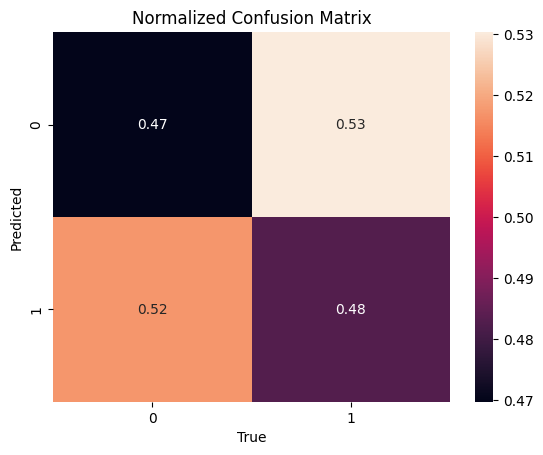

In [70]:
f = sns.heatmap(normalized_confusion_matrix, annot = True)
f.set(title = 'Normalized Confusion Matrix', xlabel = 'True', ylabel = 'Predicted')
plt.savefig("../plots/haley_heatmap_submission3.png")

# run

<h2>Make Prediction</h2>

In [106]:
pred_data = tf.keras.utils.image_dataset_from_directory("../images_test", image_size = (256, 256), labels = None)
pred_data = pred_data.unbatch()
pred_images = [img / 255.0 for img in pred_data]

Found 149 files belonging to 1 classes.


In [31]:
imgs = []
ids = []

for f in os.listdir("../images_test"):
    img = tf.keras.utils.load_img(os.path.join("../images_test", f), target_size = (256, 256, 3))
    # img = tf.keras.utils.img_to_array(img) / 255.0
    id = f.split(".")[0]
    ids.append(id)
    imgs.append(img)

# run

In [32]:
predictions = model.predict(np.array(np.array(imgs)))

# run


5/5 [==============================] - 0s 50ms/step


In [33]:
pred_data = tf.keras.utils.image_dataset_from_directory("../images_test", image_size = (256, 256), labels = None)
#pred_data = pred_data.unbatch()

Found 149 files belonging to 1 classes.


In [22]:
pred_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [23]:
predictions = model.predict(pred_data)

5/5 [==============================] - 3s 178ms/step


<h2>Format predictions for submission</h2>

In [34]:
class_predictions = np.where(predictions > 0.5, 1, 0).flatten()

# run

In [35]:
df = pd.DataFrame({'id': ids, 'class': class_predictions})
# run

In [36]:
df.to_csv("../submit_12.csv", index = None)
# run

In [37]:
df

,id,class
0,162,0
1,228,0
2,214,0
3,200,0
4,201,1
...,...,...
144,219,1
145,225,0
146,231,1
147,153,0


In [453]:
w = np.matrix()

TypeError: matrix.__new__() missing 1 required positional argument: 'data'

In [456]:
w = np.array([])

In [489]:
w = np.empty((0, 0))

In [491]:
t = np.append(w, [[(0, 1)], [(1, 2)]])

In [494]:
b = [[1, 2], [2, 1]]

In [501]:
np.empty((0, 0))

array([], shape=(0, 0), dtype=float64)

In [511]:
a = np.array([[None, None], [None, None]])

In [507]:
a[0] = 2

In [512]:
a.shape

(2, 2)